```julia
using Pkg
Pkg.activate(".")
Pkg.add("IJulia Plots Printf Revise Statistics")
Pkg.dev("..")
```

In [1]:
using Plots
using Printf
using Statistics

# The default format SVG creates figures of size 9600x6400
gr(fmt="png")

using Revise

In [2]:
using ReinforcementLearningSutton.GridWorldWindy: Point, PlayerεGreedy, GameStaticWind, GameStochasticWind, play_game

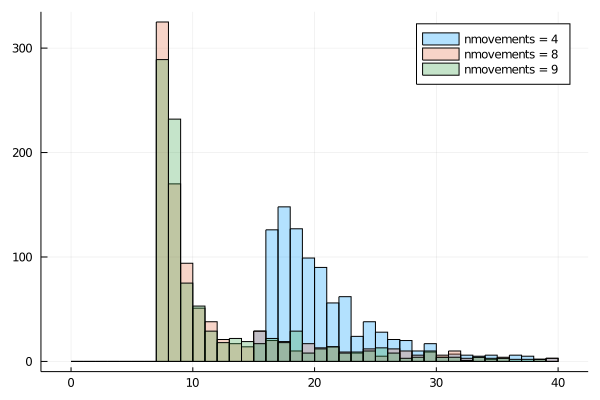

In [3]:
nrows = 7
ncols = 10
grid_wind = Array{Point, 2}(undef, ncols, nrows)

for (ncol, wind_y) in enumerate([0 0 0 1 1 1 2 2 1 0])
    for nrow in 1:nrows
        grid_wind[ncol, nrow] = Point(0, wind_y)
    end
end

pos_start = Point(1, 4)
pos_goal = Point(8, 4)

ε = 0.1
α = 0.5
γ = 1.0

ngames = 1000
allowed_movements_all = [4, 8, 9]
results = zeros(Int, ngames, length(allowed_movements_all))
for (i, allowed_movements) in enumerate(allowed_movements_all)
    game = GameStaticWind(grid_wind, pos_start, pos_goal, allowed_movements)
    player = PlayerεGreedy(game, ε, α, γ)
    results[:, i] = -[play_game(game, player) for _ in 1:1000]
end

histogram(results, bins=0:1:40, fillalpha=0.3, label=map(x -> @sprintf("nmovements = %d", x), reshape(allowed_movements_all, 1, :)))

In [4]:
median(results[900:end, :], dims=1)

1×3 Array{Float64,2}:
 18.0  8.0  7.0

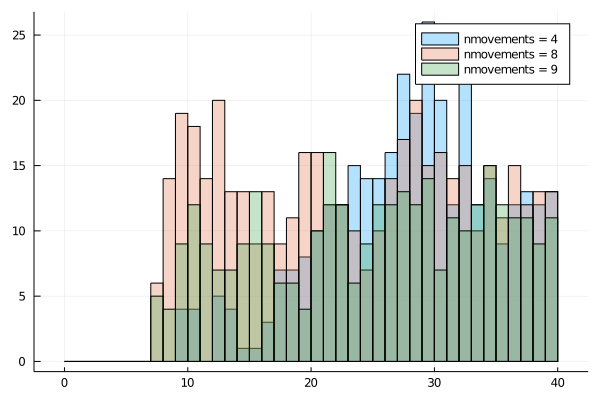

In [5]:
nrows = 7
ncols = 10
grid_wind = Array{Point, 2}(undef, ncols, nrows)

for (ncol, wind_y) in enumerate([0 0 0 1 1 1 2 2 1 0])
    for nrow in 1:nrows
        grid_wind[ncol, nrow] = Point(0, wind_y)
    end
end

pos_start = Point(1, 4)
pos_goal = Point(8, 4)

ε = 0.1
α = 0.5
γ = 1.0

ngames = 1000
allowed_movements_all = [4, 8, 9]
results = zeros(Int, ngames, length(allowed_movements_all))
for (i, allowed_movements) in enumerate(allowed_movements_all)
    game = GameStochasticWind(grid_wind, pos_start, pos_goal, allowed_movements)
    player = PlayerεGreedy(game, ε, α, γ)
    results[:, i] = -[play_game(game, player) for _ in 1:1000]
end

histogram(results, bins=0:1:40, fillalpha=0.3, label=map(x -> @sprintf("nmovements = %d", x), reshape(allowed_movements_all, 1, :)) )

In [6]:
median(results[900:end, :], dims=1)

1×3 Array{Float64,2}:
 46.0  35.0  97.0